### Praca Domowa 3
------------------
**Budowanie**
Szymon Gut, Jan Krężel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from pandas.api.types import is_numeric_dtype

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings as wr
wr.filterwarnings("ignore")

C:\Users\Agatka\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### 0. Wczytywanie i podział danych danych

In [2]:
df = pd.read_csv('data.csv')

Z jakiegoś powodu wszystkie nazwy kolumn mają poprzedzającą spację, więc ją usuniemy.

In [3]:
df.columns = df.columns.str.lstrip()

In [4]:
def split_data(X,y, random_state = 42):
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_val, y_val, stratify=y_val, test_size=0.3, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [5]:
y = np.array(df['Bankrupt?'])
X = df.drop(['Bankrupt?'], axis=1)

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

In [7]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)
print('y_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (4773, 95)
y_train: (4773,)
X_val: (1432, 95)
y_val: (1432,)
y_test: (614, 95)
y_test: (614,)


#### 1. Krótkie EDA

In [8]:
X_train.describe()


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,...,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.0,4773.000000
mean,0.504262,0.557497,0.552759,0.607735,0.607715,0.998757,0.797263,0.809187,0.303747,0.781438,...,0.807204,1.980390e+07,0.623760,0.607733,0.840443,0.280316,0.027715,0.565339,1.0,0.047192
std,0.060874,0.065915,0.062145,0.017043,0.017025,0.014483,0.011973,0.010917,0.011899,0.011813,...,0.040504,3.865474e+08,0.012689,0.017043,0.009648,0.010208,0.018559,0.014131,0.0,0.049090
min,0.024277,0.000000,0.033514,0.000000,0.000000,0.000000,0.000000,0.084286,0.235090,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.344652,0.133503,0.000000,0.000000,1.0,0.000000
25%,0.476088,0.535052,0.527116,0.600463,0.600455,0.998969,0.797385,0.809310,0.303467,0.781566,...,0.796561,9.066675e-04,0.623635,0.600459,0.840095,0.276953,0.026791,0.565158,1.0,0.024383
50%,0.502462,0.559474,0.552010,0.605940,0.605904,0.999022,0.797462,0.809375,0.303525,0.781634,...,0.810467,2.069045e-03,0.623876,0.605936,0.841148,0.278794,0.026809,0.565254,1.0,0.033730
75%,0.534637,0.588149,0.582901,0.613651,0.613593,0.999093,0.797575,0.809467,0.303584,0.781729,...,0.826101,5.242451e-03,0.624168,0.613651,0.842336,0.281491,0.026914,0.565729,1.0,0.052676
max,1.000000,1.000000,1.000000,0.665151,0.666023,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,0.665149,1.000000,0.652347,1.000000,1.000000,1.0,1.000000


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 3295 to 6313
Data columns (total 95 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   ROA(C) before interest and depreciation before interest  4773 non-null   float64
 1   ROA(A) before interest and % after tax                   4773 non-null   float64
 2   ROA(B) before interest and depreciation after tax        4773 non-null   float64
 3   Operating Gross Margin                                   4773 non-null   float64
 4   Realized Sales Gross Margin                              4773 non-null   float64
 5   Operating Profit Rate                                    4773 non-null   float64
 6   Pre-tax net Interest Rate                                4773 non-null   float64
 7   After-tax net Interest Rate                              4773 non-null   float64
 8   Non-industry income and e

Czy są jakieś braki danych?

In [10]:
X_train.isna().mean(axis=0).any()

False

Ile mamy unikalnych wartości?

In [11]:
X.columns[X_train.nunique() == 1]

Index(['Net Income Flag'], dtype='object')

Kolumna Net Income Flag ma tylko jedną wartość. Warto będzie ją usunąć, ponieważ nie będzie miała ona wpływu na przewidywanie.

Rozkład zmiennej Celu

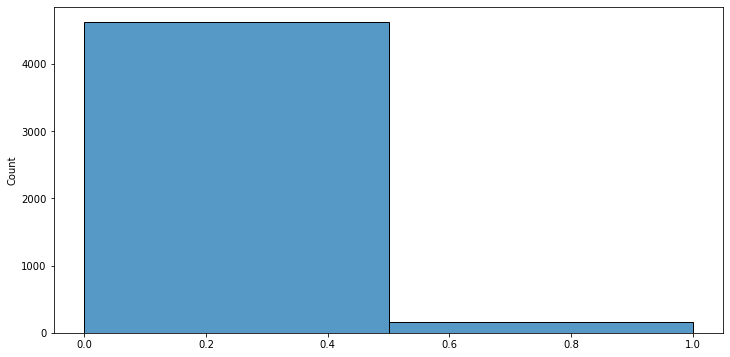

In [12]:
plt.figure(figsize=(12,6))
sns.histplot(data = y_train, bins=2)
plt.show()

#### 2. Preprocessing

Wpierw sprawdźmy czy są jacyś outlierzy

In [13]:
def count_outliers(X : pd.DataFrame, column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((X[column] < (Q1 - 1.5 * IQR)) | (X[column] > (Q3 + 1.5 * IQR))).sum()
    major_outlier_count = ((X[column] < (Q1 - 3 * IQR)) | (X[column] > (Q3 + 3 * IQR))).sum()
    return outlier_count, major_outlier_count

In [14]:
outliers_df = pd.DataFrame(columns=['Column', 'Outliers', 'Major Outliers'])
for column in X_train.columns:
    outlier_count, major_outlier_count = count_outliers(X, column)
    outliers_df = outliers_df.append({'Column': column, 'Outliers': outlier_count, 'Major Outliers': major_outlier_count}, ignore_index=True)
    # print(f"{column}:\t{outlier_count},{major_outlier_count}")
outliers_df

,Column,Outliers,Major Outliers
0,ROA(C) before interest and depreciation before...,391,63
1,ROA(A) before interest and % after tax,561,125
2,ROA(B) before interest and depreciation after tax,432,79
3,Operating Gross Margin,320,82
4,Realized Sales Gross Margin,318,82
...,...,...,...
90,Liability to Equity,404,140
91,Degree of Financial Leverage (DFL),1503,998
92,Interest Coverage Ratio (Interest expense to E...,1421,859
93,Net Income Flag,0,0


Czy jakieś zmienne są odwrotnie skorelowane ze zmienną celu?

In [15]:
df_train = X_train.copy()
df_train['Bankrupt?'] = y_train
correlation = df_train.corr()
negatively_correlated_columns = df_train.columns[correlation['Bankrupt?'] < 0]
len(negatively_correlated_columns)

65

**Usuwanie zmiennych skorelowanych**

Wpierw wyznaczamy feature importance (funkcja mutual_info_classif) dla każdej zmiennej, a następnie dla zmiennych skorelowanych (>0.65) usuwamy tę mniej informatywną. Dokładniejszy opis procesu w komentarzach funkcji

In [16]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi, index = X_train.columns)

In [17]:
def remove_highly_correlated(X, mi, threshold=0.65):
    # znajdź pary (różnych) zmiennych o korelacji większej niż threshold
    correlation = X.corr()
    correlation = correlation.melt(ignore_index=False).reset_index(drop=False).rename(columns={'index':'Var 1', 'variable': 'Var 2', 'value': 'Corr'})
    correlation = correlation[(np.abs(correlation['Corr']) > threshold) & (correlation['Var 1'] != correlation['Var 2'])].sort_values(by='Corr', ascending=False)

    # idąc od najbardziej skorelowanych odrzuć tę mniej ważną
    # jest to bardzo prosty i naiwny algorytm, ponieważ nie maksymalizuje on średniej pozostałej wartości feature importance
    # ani nie minimalizuje liczby usuniętych zmiennych

    removed_features = set()
    for _, row in correlation.iterrows():
        var_1 = row['Var 1']
        var_2 = row['Var 2']
        if (var_1 in removed_features or var_2 in removed_features):
            continue # do not remove unecessary columns
        fi_1 = mi[var_1]
        fi_2 = mi[var_2]
        if (fi_2 < fi_1):
            removed_features.add(var_2)
        else:
            removed_features.add(var_1)

    return X.drop(list(removed_features), axis=1), removed_features

    

Poniżej przedstawiony jest wykres feature importance dla 10 najlepszych zmiennych (aby zachować czytelność)

Do trenowania modelu wybierzemy 30 najlepszych, po usunięciu zmiennych silnie skorelowanych.

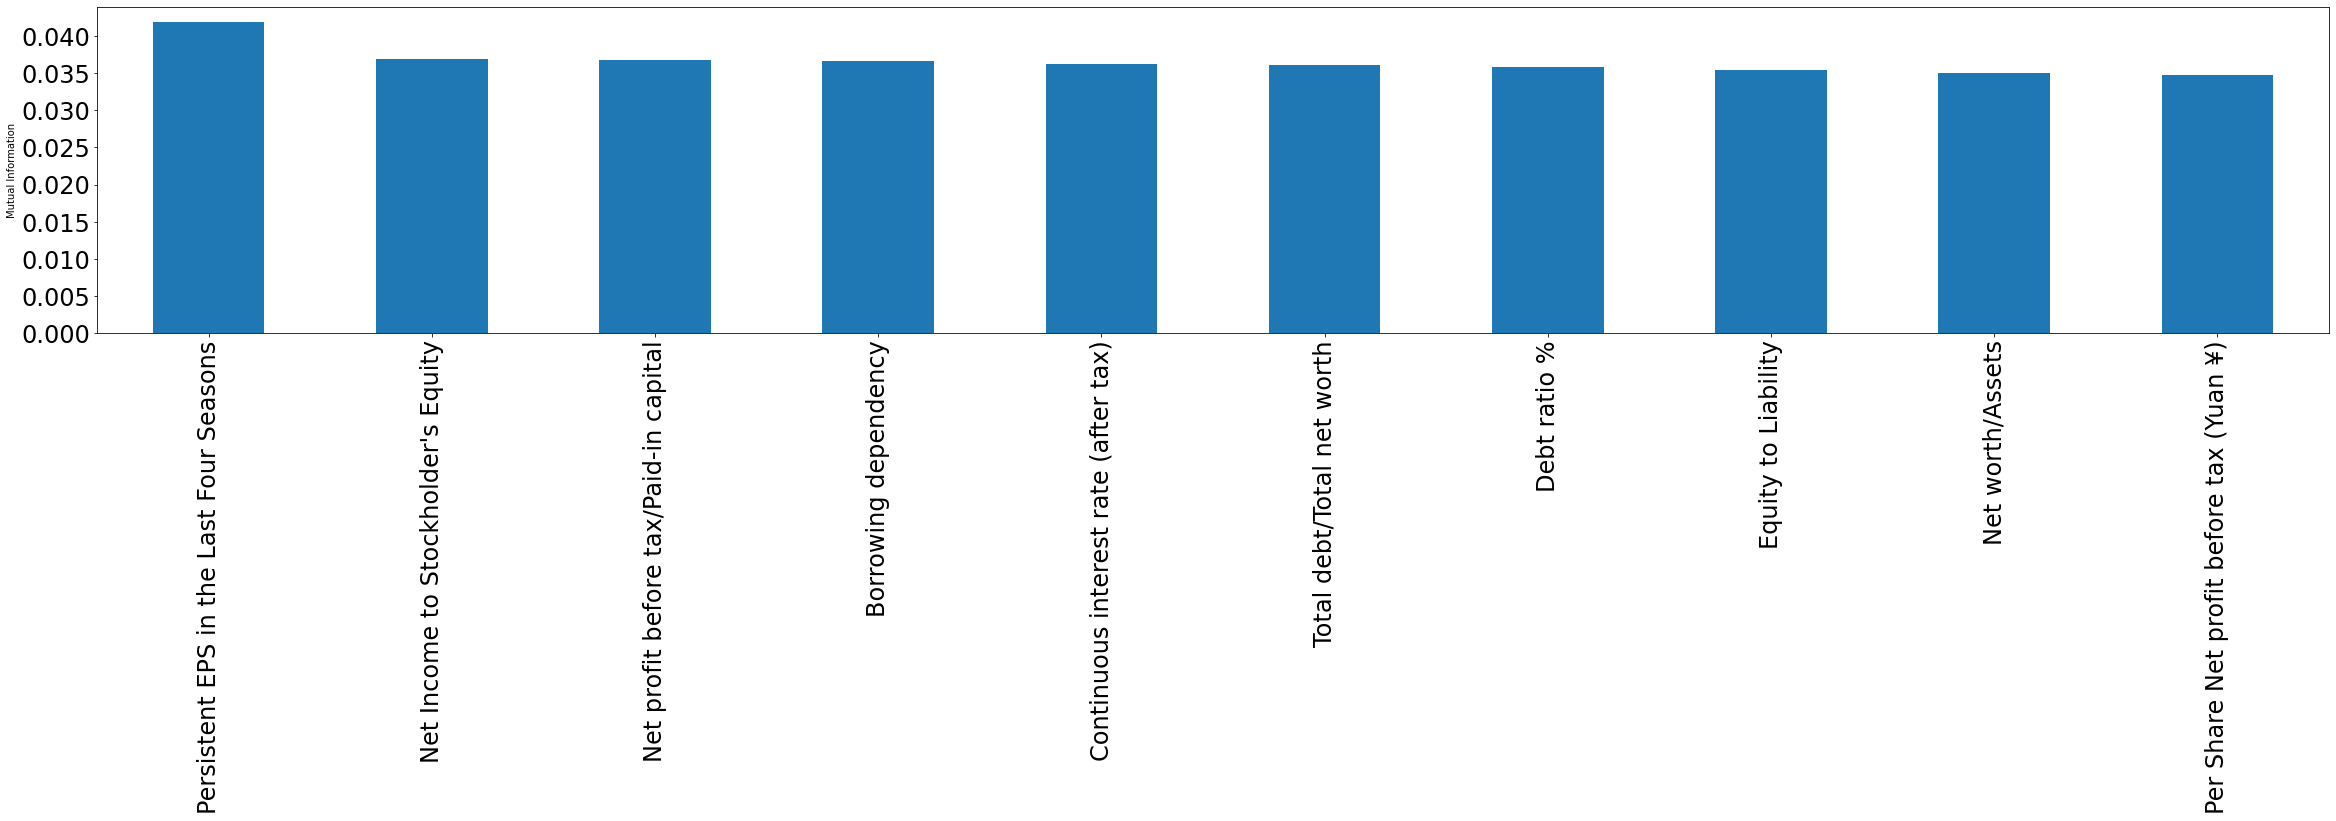

In [18]:
plt.figure(figsize=(40, 6))

mi = pd.Series(mi, index=X_train.columns)
top_10_features = mi.sort_values(ascending=False).head(10)
top_10_features.plot.bar(fontsize=24)
plt.ylabel('Mutual Information')
plt.show()

In [19]:
X_train_reduced = remove_highly_correlated(X, mi)[0]

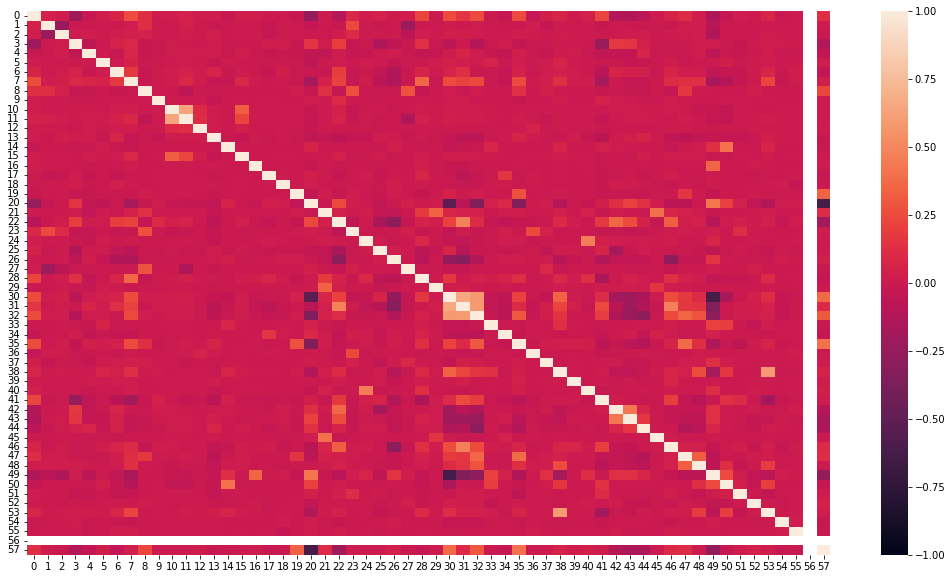

In [20]:
plt.figure(figsize=(18, 10))
sns.heatmap(X_train_reduced.corr(), vmin=-1, vmax=1,
        xticklabels=np.arange(X_train_reduced.columns.shape[0]), # liczby dla czytelności, poniważ nazwy kolumn są zbyt długie
        yticklabels=np.arange(X_train_reduced.columns.shape[0]))
plt.show()


Zmienna ```Net Income Flag``` nie jest w żaden sposób informatywna. Będziemy ją usuwać

In [29]:
X_train_reduced.columns[56]

'Net Income Flag'

#### 3. Pipeline

Teraz stworzymy pipeline, który obejmuje wszystkie wcześniej opisane transformacje

In [22]:
# Krok do usuwania Net Income Flag
class ColumnDropper:
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        return X.drop(column, axis=1)

# Krok do wyrzucania zbyt skorelowanych zmiennych
class CorrelatedFeatureDropper:
    def __init__(self, threshold=0.65):
        self.threshold = threshold

    def fit(self, X, y):
        mi = mutual_info_classif(X, y)
        mi = pd.Series(mi, index=X.columns)
        self.dropped_columns = remove_highly_correlated(X, mi)[1]
        return self

    def transform(self, X, y = None):
        return X.drop(self.dropped_columns, axis=1)

# Zmiana korelacji ujemnej na dodatnią
class TrendTransformer:
    def __init__(self):
        return None

    def fit(self, X, y = None):
        df = X.copy()
        df['y'] = y
        correlation = df.corr()
        self.columns = df.columns[correlation['y'] < 0]
        return self

    def transform(self, X, y= None):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = -X[column]
        return X_copy

# Przycinanie outlierów
class OutlierClamper:
    def __init__(self, min_quantile = 0.025, max_quantile = 0.975):
        self.min_q = min_quantile
        self.max_q = max_quantile

    def fit(self, X, y = None):
        return self

    def transform(self, X : pd.DataFrame, y = None):
        X_copy = X.copy()
        for column in X.columns:
            if not is_numeric_dtype(X[column]):
                continue
            min_v = X[column].quantile(self.min_q)
            max_v = X[column].quantile(self.max_q)
            X_copy.loc[X[column] < min_v, column] = min_v
            X_copy.loc[X[column] > max_v, column] = max_v
        return X_copy

In [23]:
preprocessor = Pipeline(
    steps=[
        ('NIFDropper', ColumnDropper('Net Income Flag')),
        ('CorrelatedFeatureDropper', CorrelatedFeatureDropper()),
        ('OutlierClamper', OutlierClamper()),
        ('TrendTransformer', TrendTransformer()),
        ('MinMaxScaler', MinMaxScaler()),
        ('FeatureSelector', SelectKBest(mutual_info_classif, k=30)),
    ]
)

#### 4. Budowanie Modeli

In [73]:
def evaluate(model : Pipeline, X, y, suppress_output = False):
    y_pred = model.predict(X)
    if not suppress_output:
        
        print(f"Accuracy score: ", accuracy_score(y,y_pred))
        print("precision: ", precision_score(y,y_pred))
        print("recall: ", recall_score(y,y_pred))
        print("f1: ", f1_score(y,y_pred))

        sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")

    return f1_score(y,y_pred)

**Regresja logistyczna**

In [74]:
lr = Pipeline(
    steps=[
        ('Preprocessor', preprocessor),
        ('LogisticRegressor', LogisticRegression(random_state=0))
    ],
)
lr.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 Pipeline(steps=[('NIFDropper',
                                  <__main__.ColumnDropper object at 0x000001D3BBCB8190>),
                                 ('CorrelatedFeatureDropper',
                                  <__main__.CorrelatedFeatureDropper object at 0x000001D3BBCBD6A0>),
                                 ('OutlierClamper',
                                  <__main__.OutlierClamper object at 0x000001D3BBCBD5B0>),
                                 ('TrendTransformer',
                                  <__main__.TrendTransformer object at 0x000001D3BBCBD100>),
                                 ('MinMaxScaler', MinMaxScaler()),
                                 ('FeatureSelector',
                                  SelectKBest(k=30,
                                              score_func=<function mutual_info_classif at 0x000001D3B9EC2940>))])),
                ('LogisticRegressor', LogisticRegression(random_state=0))])

Accuracy score:  0.9713687150837989
precision:  0.7777777777777778
recall:  0.15217391304347827
f1:  0.2545454545454546


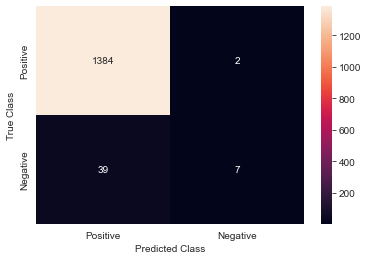

In [75]:
lr_f1 = evaluate(lr, X_val, y_val)

**XGBClassifier**

In [76]:
xgbc = Pipeline(
    steps=[
        ('Preprocessor', preprocessor),
        ('XGBClassifier', XGBClassifier(n_estimators = 100, random_state=0, max_depth=25, use_label_encoder=False, eval_metric='logloss'))
    ],
)
xgbc.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 Pipeline(steps=[('NIFDropper',
                                  <__main__.ColumnDropper object at 0x000001D3BBCB8190>),
                                 ('CorrelatedFeatureDropper',
                                  <__main__.CorrelatedFeatureDropper object at 0x000001D3BBCBD6A0>),
                                 ('OutlierClamper',
                                  <__main__.OutlierClamper object at 0x000001D3BBCBD5B0>),
                                 ('TrendTransformer',
                                  <__main__.TrendTransformer object at 0x000001D3BBCBD100>)...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=25, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, p

Accuracy score:  0.9692737430167597
precision:  0.5625
recall:  0.1956521739130435
f1:  0.2903225806451613


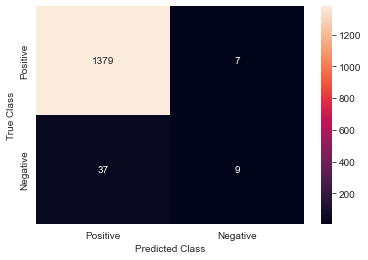

In [77]:
xgbc_f1 = evaluate(xgbc, X_val, y_val)

**Random Forest Classifier**

In [78]:
rfc = Pipeline(
    steps=[
        ('Preprocessor', preprocessor),
        ('RFC', RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 0))
    ],
)
rfc.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 Pipeline(steps=[('NIFDropper',
                                  <__main__.ColumnDropper object at 0x000001D3BBCB8190>),
                                 ('CorrelatedFeatureDropper',
                                  <__main__.CorrelatedFeatureDropper object at 0x000001D3BBCBD6A0>),
                                 ('OutlierClamper',
                                  <__main__.OutlierClamper object at 0x000001D3BBCBD5B0>),
                                 ('TrendTransformer',
                                  <__main__.TrendTransformer object at 0x000001D3BBCBD100>),
                                 ('MinMaxScaler', MinMaxScaler()),
                                 ('FeatureSelector',
                                  SelectKBest(k=30,
                                              score_func=<function mutual_info_classif at 0x000001D3B9EC2940>))])),
                ('RFC',
                 RandomForestClassifier(criterion='entropy', ran

Accuracy score:  0.9699720670391061
precision:  1.0
recall:  0.06521739130434782
f1:  0.12244897959183672


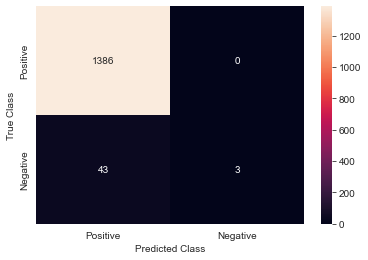

In [79]:
rfc_f1 = evaluate(rfc, X_val, y_val)

Widać, że ```precision``` i ```recall``` nie są wystarczająco wysokie. Jest to spowodowane bardzo małą liczbą obserwacji firm, które zbankrutowały (```Bankrupt?``` == 1).

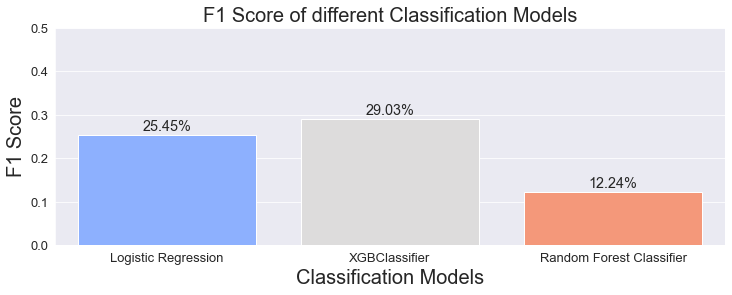

In [80]:
f1_scores=[lr_f1, xgbc_f1, rfc_f1]
models=["Logistic Regression", "XGBClassifier", "Random Forest Classifier"]

plt.figure(figsize=(12, 4))
sns.set_style("darkgrid")
ax = sns.barplot(x=models, y=f1_scores, palette = "coolwarm", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("F1 Score", fontsize = 20)
plt.title("F1 Score of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 13, horizontalalignment = 'center')
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height + 0.01), ha='center', fontsize = 'x-large')
plt.ylim([0, 0.5])
plt.show()


Najlepiej (pod względem F1 Score) sprawuje się model XGBClassifier

#### 5. Dostrajanie hiperparametrów

Ponieważ preprocessing trwa dość długo to wpierw przerobimy dane używając naszego pipeline, a potem tak przerobione dane będzie dostarczać osobno do modeli z różnymi wartościami hiperparametrów.

In [24]:
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_val_processed = preprocessor.transform(X_val)

In [25]:
X_val_processed

array([[0.76986753, 0.2814505 , 0.56457844, ..., 0.18713753, 0.17895512,
        0.55578654],
       [0.66224123, 0.22432805, 0.67147835, ..., 0.30153198, 0.20402227,
        0.50396839],
       [0.51604282, 0.20147906, 0.36310413, ..., 0.25100895, 0.1858363 ,
        0.54064705],
       ...,
       [0.7925485 , 0.30511552, 0.71769893, ..., 0.30354536, 0.18152207,
        0.55005141],
       [0.60041028, 0.33173866, 1.        , ..., 0.37017316, 0.23163738,
        0.45603657],
       [0.7716011 , 0.39436936, 1.        , ..., 0.42744874, 0.02476894,
        1.07709554]])

**Regresja Logistyczna**

Największym problemem naszych danych jest mała liczba obserwacji firm, które zbankrutowały. Możemy pomóc modelowi regresji podając odpowiednie wagi dla przewidywanych klas. Domyślnie ```LogisticRegressor``` nie używa żadnych wag.

In [82]:
lr_balanced = LogisticRegression(class_weight='balanced', random_state=0)
lr_balanced.fit(X_train_processed, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

Accuracy score:  0.8680167597765364
precision:  0.17937219730941703
recall:  0.8695652173913043
f1:  0.29739776951672864


0.29739776951672864

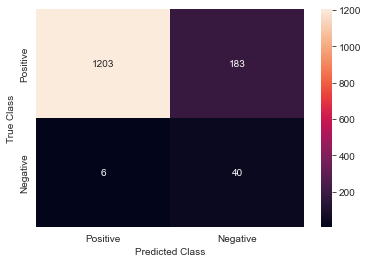

In [83]:
evaluate(lr_balanced, X_val_processed, y_val)

Wcześniej problemem były przypadki False Negative. Teraz problemem są przypadki False Positive jednak F1 Score się poprawił. Sprawdźmy czy uda nam się znaleźć jakąś optymalną wagę dla klas. W trybie ```Balanced``` wagi to 

    n_samples / (n_classes * np.bincount(y))

Czyli u nas


In [84]:
y_train.shape[0] / (2 * np.bincount(y_train))

array([ 0.51667027, 15.49675325])

Czyli mniej więcej 1:30. Zobaczmy czy uda nam się znaleźć jakiś lepszy stosunek wag. będziemy szuakć w przedziale 1:[0:30]

In [85]:
lr_f1_scores = np.empty(31)
for i in np.arange(0, 31):
    lr_hyper = LogisticRegression(class_weight={0:1, 1:i}, random_state=0, max_iter=200)
    lr_hyper.fit(X_train_processed, y_train)
    y_pred = lr_hyper.predict(X_val_processed)
    lr_f1_scores[i] = f1_score(y_val, y_pred)
    

Text(0, 0.5, 'F1 Score')

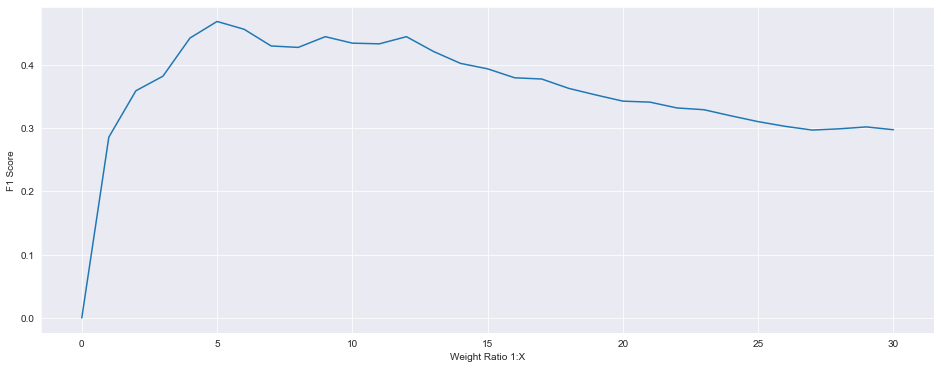

In [86]:
plt.figure(figsize=(16, 6))
sns.lineplot(x=np.arange(0, 31), y=lr_f1_scores)
plt.xlabel("Weight Ratio 1:X")
plt.ylabel("F1 Score")

Najlepszy wynik uzyskujemy dla stosunku 1:5. Zobaczmy jak wygląda Confusion Matrix dla tego parametru

*Walidacja: warto dodać, że najlepszy stosunek 1:X zmienia się za każdym wywołaniem kodu*

Accuracy score:  0.9587988826815642
precision:  0.4
recall:  0.5652173913043478
f1:  0.46846846846846846


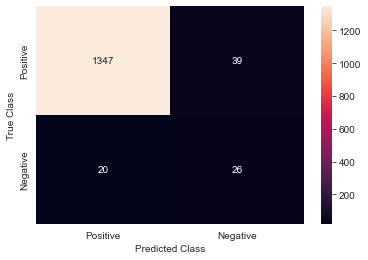

In [99]:
lr_hyper = LogisticRegression(class_weight={0:1, 1:5}, random_state=0, max_iter=200)
lr_hyper.fit(X_train_processed, y_train)
lr_f1_hyper = evaluate(lr_hyper, X_val_processed, y_val)

**XGBClassifier**
Dla XGBClassifer sprawdzimy znaczenie parametrów ```max_depth``` oraz ```learning_rate```

In [100]:
max_depths = np.arange(5, 15, 1)
learning_rates = np.logspace(-0.6, 0.6, 50)

xgbc_f1_scores_train = np.empty(shape=(max_depths.shape[0], learning_rates.shape[0]))       # bias
xgbc_f1_scores_val = np.empty(shape=(max_depths.shape[0], learning_rates.shape[0]))         # variance

In [101]:
from IPython.display import clear_output

In [102]:
# %%capture --no-stdout

for i, depth in enumerate(max_depths):
    for j, learning_rate in enumerate(learning_rates):
        clear_output(wait=True)
        print(f"Evaluating model {i * len(learning_rates) + j} of {len(learning_rates) * len(max_depths)}...\n")

        xgbc_hyper = XGBClassifier(
            random_state = 0, 
            max_depth=depth, 
            learning_rate=learning_rate, 
            n_estimators=10, 
            use_label_encoder=False, eval_metric='logloss')
        xgbc_hyper.fit(X_train_processed, y_train)

        xgbc_f1_scores_train[i, j] = f1_score(y_train, xgbc_hyper.predict(X_train_processed))
        xgbc_f1_scores_val[i, j] = f1_score(y_val, xgbc_hyper.predict(X_val_processed))


Evaluating model 499 of 500...



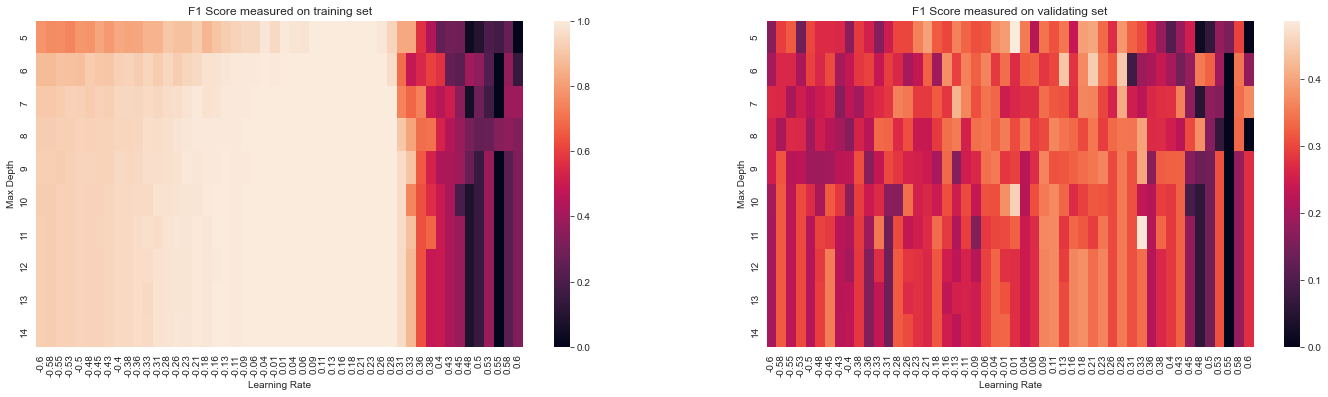

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))
axes[0].title.set_text("F1 Score measured on training set")
axes[1].title.set_text("F1 Score measured on validating set")

# Ucinam outlierów, aby lepiej było widać skalę problemu
sns.heatmap(ax = axes[0], data = xgbc_f1_scores_train, xticklabels=np.log10(learning_rates).round(2), yticklabels=max_depths)
sns.heatmap(ax = axes[1], data = xgbc_f1_scores_val, xticklabels=np.log10(learning_rates).round(2), yticklabels=max_depths)
axes[0].set(xlabel="Learning Rate", ylabel="Max Depth")
axes[1].set(xlabel="Learning Rate", ylabel="Max Depth")
plt.show()

Widzimy, że zdecydowanie większy wpływ ma tutaj ```Learning Rate``` i optymalny zakres to około 10^(0.06) (X_val)

In [104]:
argidx = np.unravel_index(xgbc_f1_scores_val.argmax(), (max_depths.shape[0], learning_rates.shape[0]))
argmax = max_depths[argidx[0]], learning_rates[argidx[1]]
argmax

(5, 1.0285961583377596)

Accuracy score:  0.973463687150838
precision:  0.6428571428571429
recall:  0.391304347826087
f1:  0.4864864864864865


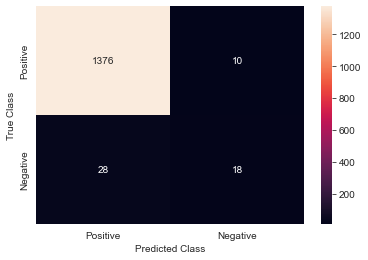

In [105]:
xgbc_hyper = XGBClassifier(
    random_state = 0,
    max_depth=argmax[0], 
    learning_rate=argmax[1], 
    n_estimators=10, 
    use_label_encoder=False, eval_metric='logloss')
xgbc_hyper.fit(X_train_processed, y_train)
xgbc_f1_hyper = evaluate(xgbc_hyper, X_val_processed, y_val)

**Random Forest Classifer**

Na koniec zajmiemy się Lasem Losowym. Tutaj także będziemy analizować ```max_depth```, ale zamiast ```learning_rate``` sprawdzimy ```min_samples_split```

In [111]:
max_depths = np.arange(5, 15, 1)
min_splits = np.logspace(start = -5, stop = -2, num=25)
rfc_f1_scores_train = np.empty(shape=(max_depths.shape[0], min_splits.shape[0]))    # bias
rfc_f1_scores_val = np.empty(shape=(max_depths.shape[0], min_splits.shape[0]))      # variance

In [112]:
for i, depth in enumerate(max_depths):
    for j, split in enumerate(min_splits):
        clear_output(wait=True)
        print(f"Evaluating model {i * len(min_splits) + j} of {len(min_splits) * len(max_depths)}...\n")
        rfc_hyper = RandomForestClassifier(random_state = 0, n_estimators=15, max_depth=depth, min_samples_split=split)
        rfc_hyper.fit(X_train_processed, y_train)

        rfc_f1_scores_train[i, j] = f1_score(y_train, rfc_hyper.predict(X_train_processed))
        rfc_f1_scores_val[i, j] = f1_score(y_val, rfc_hyper.predict(X_val_processed))

Evaluating model 249 of 250...



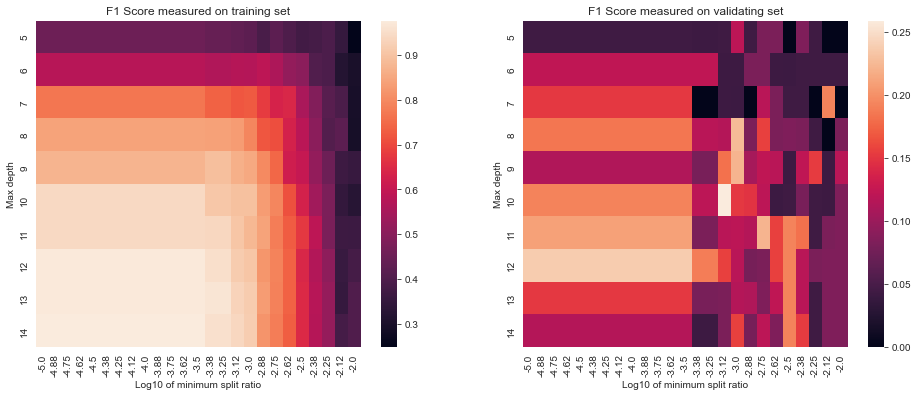

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].title.set_text("F1 Score measured on training set")
axes[1].title.set_text("F1 Score measured on validating set")

# Ucinam outlierów, aby lepiej było widać skalę problemu
sns.heatmap(ax = axes[0], data = rfc_f1_scores_train, xticklabels=np.log10(min_splits).round(2), yticklabels=max_depths)
sns.heatmap(ax = axes[1], data = rfc_f1_scores_val, xticklabels=np.log10(min_splits).round(2), yticklabels=max_depths)
axes[0].set(xlabel="Log10 of minimum split ratio", ylabel="Max depth")
axes[1].set(xlabel="Log10 of minimum split ratio", ylabel="Max depth")
plt.show()

Widzimy efekty przeuczenia się dla głębokich drzew oraz dla drzew, które dokonują bardzo drobnych podziałów.

In [114]:
argidx_rf = np.unravel_index(rfc_f1_scores_val.argmax(), (max_depths.shape[0], min_splits.shape[0]))
argmax_rf = max_depths[argidx_rf[0]], min_splits[argidx_rf[1]]
argmax_rf

(10, 0.0007498942093324559)

Accuracy score:  0.9720670391061452
precision:  0.875
recall:  0.15217391304347827
f1:  0.2592592592592593


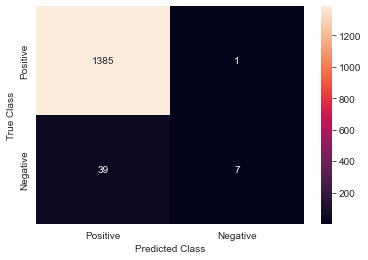

In [134]:
rfc_hyper = RandomForestClassifier(random_state = 0, n_estimators=15, max_depth=argmax_rf[0], min_samples_split=argmax_rf[1])
rfc_hyper.fit(X_train_processed, y_train)
rfc_f1_hyper = evaluate(rfc_hyper, X_val_processed, y_val)

**Poprawione wyniki**

In [135]:
scores_table = pd.DataFrame({
    'Model': ['LR', 'LR', 'XGBC', 'XGBC', 'RFC', 'RFC'], 
    'Optimised': ['NO', 'YES'] * 3, 
    'F1 Score': [lr_f1, lr_f1_hyper, xgbc_f1, xgbc_f1_hyper, rfc_f1, rfc_f1_hyper]})

<AxesSubplot:xlabel='Model', ylabel='F1 Score'>

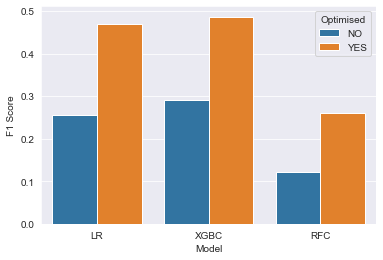

In [136]:
sns.barplot(data=scores_table, x = 'Model', y='F1 Score', hue='Optimised')

Oczywiście mierzenie tylko za pomocą ```F1 Score``` nie jest wystarczające. W zależności od tego co chcemy osiągnąć powinniśmy patrzeć na różne ewaluacje.

#### 6. Podsumowanie

Najlepiej sprawdzał się model XGBClassifer w szczególności po optymalizacji hiperparametrów. Regresja logistyczna jest zaraz za nim jednak dzięki możliwości ustawienia wag może okazać się skuteczniejsza dla danego problemu. To wynika z tego, że raczej będziemy woleli stwierdzić, że jakaś firma zbankrutuje i się mylić niż stwierdzić, że firma się utrzyma gdy w rzeczywistości niedługo upadnie. To jest szczególnie ważne np przy udzielaniu kredytów przez banki.

-------------
## Walidacja
Agata Kopyt, Zuzanna Kotlińska

In [137]:
# może to chwilkę zająć
preprocessor.fit(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

### Modele bez optymalizacji

Zaczniemy od przetestowania modeli bez dostrojonych parametrów.

**Regresja Logistyczna**

Accuracy score:  0.9674267100977199
precision:  0.5
recall:  0.15
f1:  0.23076923076923075


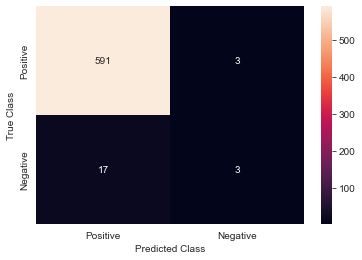

In [138]:
lr_f1_test = evaluate(lr, X_test, y_test)

Uzyskane wyniki i macierz konfuzji są bardzo podobne do wyników z próbki treningowej.

**XGBClassifier**

Accuracy score:  0.9641693811074918
precision:  0.3333333333333333
recall:  0.1
f1:  0.15384615384615383


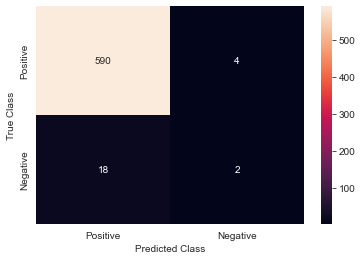

In [164]:
xgbc_f1_test = evaluate(xgbc, X_test, y_test)

Uzyskane wyniki znacząco odbiegają od próbki treningowej, dla której xgbc sprawdził się najlepiej, nawet bez strojenia parametrów.

**Random Forest Classifier**

Accuracy score:  0.9674267100977199
precision:  0.5
recall:  0.05
f1:  0.09090909090909091


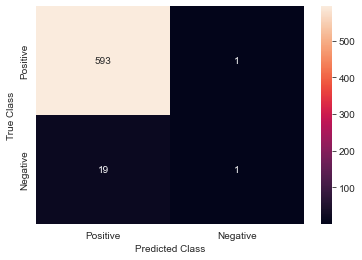

In [140]:
rfc_f1_test = evaluate(rfc, X_test, y_test)

Wyniki uzyskane na próbce testowej zgadzają się z próbką treningową.

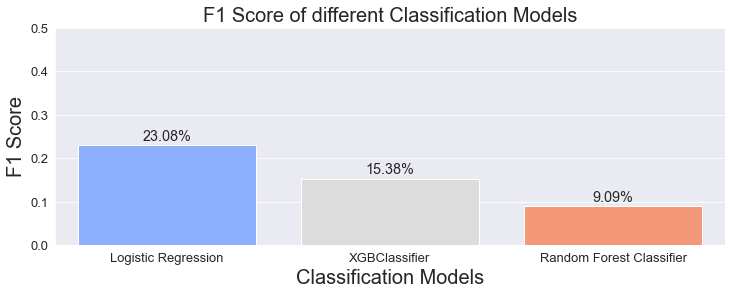

In [141]:
f1_scores=[lr_f1_test, xgbc_f1_test, rfc_f1_test]
models=["Logistic Regression", "XGBClassifier", "Random Forest Classifier"]

plt.figure(figsize=(12, 4))
sns.set_style("darkgrid")
ax = sns.barplot(x=models, y=f1_scores, palette = "coolwarm", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("F1 Score", fontsize = 20)
plt.title("F1 Score of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 13, horizontalalignment = 'center')
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height + 0.01), ha='center', fontsize = 'x-large')
plt.ylim([0, 0.5])
plt.show()

Najlepiej pod względem f1-score sprawdziła się regresja logistyczna. Przyjrzymy się jeszcze wynikom po próbie optymalizacji modeli. Co ciekawe, wszystkie modele uzyskały bardzo wysokie accuracy.

### Modele z optymalizacjami

**Regresja logistyczna**

W tym modelu dostrajanym parametrem są wagi dla przewidywanych klas. Znajdziemy najlepszy dobór `class_weight` dla próbki testowej, aby sprawdzić czy w ogóle możliwe byłoby uzyskać wyższe wyniki od tych uzyskanych dla parametru ustalonego na próbce treningowej.

Jako, że próbki były dzielone proporcjonalnie względem zmiennej celu, to najlepszy stosunek wag powienien znaleźć się mniej więcej w tym samym przedziale co dla próbki treningowej.

In [142]:
y_test.shape[0] / (2 * np.bincount(y_test))

array([ 0.51683502, 15.35      ])

Istotnie, należy szukać w przedziale 1:[0:30]. Korzystając z metody użytej na próbce treningowej, zbadamy wyniki f1-score w zależności od wybranego stosunku  `class_weight`.

In [157]:
lr_f1_scores_test = np.empty(31)
for i in np.arange(0, 31):
    lr_hyper = LogisticRegression(class_weight={0:1, 1:i}, random_state=0, max_iter=200)
    lr_hyper.fit(X_train_processed, y_train)
    y_pred_test= lr_hyper.predict(X_test_processed)
    lr_f1_scores_test[i] = f1_score(y_test, y_pred_test)

Text(0, 0.5, 'F1 Score')

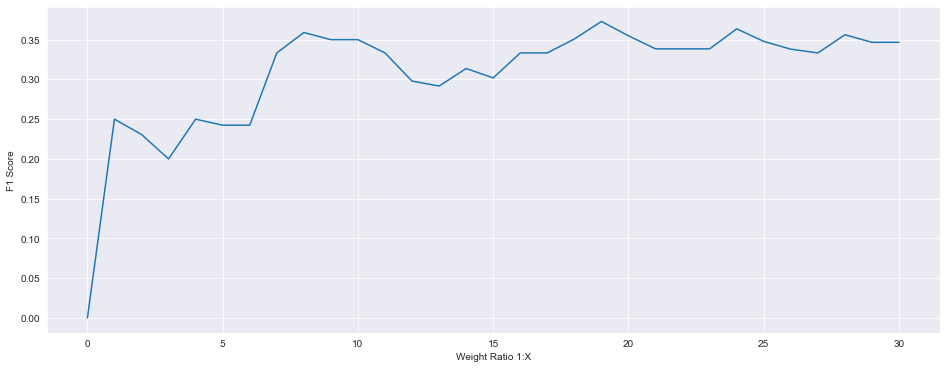

In [158]:
plt.figure(figsize=(16, 6))
sns.lineplot(x=np.arange(0, 31), y=lr_f1_scores_test)
plt.xlabel("Weight Ratio 1:X")
plt.ylabel("F1 Score")

Z wykresu podejrzewamy, że najlepsze wyniki są osiągane dla 1:19. Wyświetlimy konkretne wartości f1-score dla wyników z X w predziałe [9,20].

In [145]:
lr_f1_scores_test[9:21]

array([0.35      , 0.35      , 0.33333333, 0.29787234, 0.29166667,
       0.31372549, 0.30188679, 0.33333333, 0.33333333, 0.35087719,
       0.37288136, 0.35483871])

Istotnie, dla próbki walidacyjnej lepszy stosunek wag to 1:19, a różnica w f1 score pomiędzy 1:19 a 1:5 jest znacząca.

Accuracy score:  0.9397394136807817
precision:  0.28205128205128205
recall:  0.55
f1:  0.3728813559322034


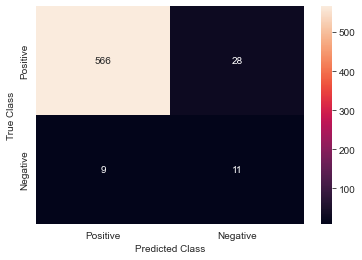

In [162]:
lr_hyper = LogisticRegression(class_weight={0:1, 1:19}, random_state=0, max_iter=200)
lr_hyper.fit(X_train_processed, y_train)
lr_f1_hyper_test = evaluate(lr_hyper, X_test_processed, y_test)

Accuracy score:  0.9592833876221498
precision:  0.3076923076923077
recall:  0.2
f1:  0.24242424242424246


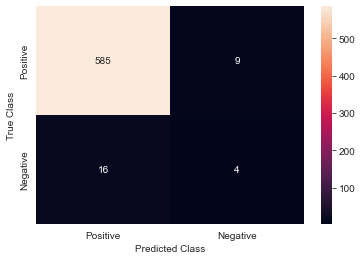

In [163]:
lr_hyper = LogisticRegression(class_weight={0:1, 1:5}, random_state=0, max_iter=200)
lr_hyper.fit(X_train_processed, y_train)
lr_f1_hyper_test = evaluate(lr_hyper, X_test_processed, y_test)

Model z `class_weight={0:1, 1:5}` ma co prawda lepsze accuracy, ale częściej przewiduje wartość pozytywną podczas gdy w rzeczywistości powinna być negatywna - jest to niebezpieczne np. (jak to już zespół budujący zauważył) podczas decyzji o udzieleniu kredytu. Oczywiście nie oczekiwałyśmy, że 1:5 okaże się najlepszym `class_weight` także na tej próbce, jednakże różnica ok. 10 punktów procentowych (przy ogólnie niskim f1 score) do modelu z 1:19 jest rażąca. Wynik f1-score poprawił się bardzo nieznacznie w porównaniu do modelu z parametrem domyślnym, w związku z tym uznajemy 1:5 za nieszczególnie trafny wybór.

**XGBClassifier**

W tym modelu dostrajano parametry `max_depth` oraz `learning_rate`. Najpierw stworzymy model, który poda najlepsze parametry dla próbki testowej i porównamy wyniki z modelem z parametrami uzyskanymi na podstawie próbki budującej.

In [147]:
# %%capture --no-stdout
xgbc_f1_scores_test = np.empty(shape=(max_depths.shape[0], learning_rates.shape[0]))         # variance

for i, depth in enumerate(max_depths):
    for j, learning_rate in enumerate(learning_rates):
        clear_output(wait=True)
        print(f"Evaluating model {i * len(learning_rates) + j} of {len(learning_rates) * len(max_depths)}...\n")

        xgbc_hyper = XGBClassifier(
            random_state = 0, 
            max_depth=depth, 
            learning_rate=learning_rate, 
            n_estimators=10, 
            use_label_encoder=False, eval_metric='logloss')
        xgbc_hyper.fit(X_train_processed, y_train)

        xgbc_f1_scores_train[i, j] = f1_score(y_train, xgbc_hyper.predict(X_train_processed))
        xgbc_f1_scores_test[i, j] = f1_score(y_test, xgbc_hyper.predict(X_test_processed))


Evaluating model 499 of 500...



In [148]:
argidx_test = np.unravel_index(xgbc_f1_scores_test.argmax(), (max_depths.shape[0], learning_rates.shape[0]))
argmax_test = max_depths[argidx_test[0]], learning_rates[argidx_test[1]]
argmax_test

(8, 1.1513953993264472)

Dla próbki testowej najlepsze `max_depth`=8, a `learning_rate` to ok. 1.15

Accuracy score:  0.9739413680781759
precision:  0.6666666666666666
recall:  0.4
f1:  0.5


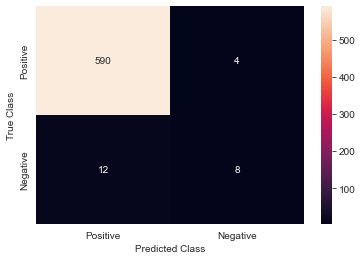

In [149]:
xgbc_hyper = XGBClassifier(
    random_state = 0,
    max_depth=argmax_test[0], 
    learning_rate=argmax_test[1], 
    n_estimators=10, 
    use_label_encoder=False, eval_metric='logloss')
xgbc_hyper.fit(X_train_processed, y_train)
xgbc_f1_hyper_test = evaluate(xgbc_hyper, X_test_processed, y_test)

Accuracy score:  0.9690553745928339
precision:  0.5454545454545454
recall:  0.3
f1:  0.3870967741935483


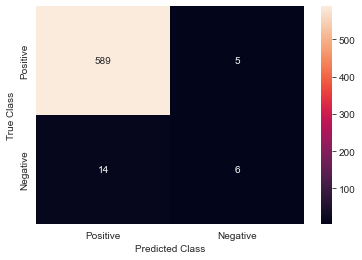

In [165]:
xgbc_hyper = XGBClassifier(
    random_state = 0,
    max_depth=argmax[0], 
    learning_rate=argmax[1], 
    n_estimators=10, 
    use_label_encoder=False, eval_metric='logloss')
xgbc_hyper.fit(X_train_processed, y_train)
xgbc_f1_hyper_test = evaluate(xgbc_hyper, X_test_processed, y_test)

Parametry dobrane dla próbki treningowej nie okazały się najbardziej optymalnymi dla próbki testowej, ale uważamy, że dały zadowalające rezultaty. Dla obu doborów parametrów wynik f1-score znacząco się poprawił.

**Random Forest**

Tym razem dostrajano parametry `max_depth` oraz ```min_samples_split```. Tak samo jak dla XGBC, najpierw stworzymy model, który poda najlepsze parametry dla próbki testowej i porównamy wyniki z modelem z parametrami uzyskanymi na podstawie próbki budującej.

In [150]:
rfc_f1_scores_test = np.empty(shape=(max_depths.shape[0], min_splits.shape[0]))          # variance

for i, depth in enumerate(max_depths):
    for j, split in enumerate(min_splits):
        clear_output(wait=True)
        print(f"Evaluating model {i * len(min_splits) + j} of {len(min_splits) * len(max_depths)}...\n")
        rfc_hyper = RandomForestClassifier(random_state = 0, n_estimators=15, max_depth=depth, min_samples_split=split)
        rfc_hyper.fit(X_train_processed, y_train)

        rfc_f1_scores_train[i, j] = f1_score(y_train, rfc_hyper.predict(X_train_processed))
        rfc_f1_scores_test[i, j] = f1_score(y_test, rfc_hyper.predict(X_test_processed))

Evaluating model 249 of 250...



In [151]:
argidx_rf_test = np.unravel_index(rfc_f1_scores_test.argmax(), (max_depths.shape[0], min_splits.shape[0]))
argmax_rf_test = max_depths[argidx_rf_test[0]], min_splits[argidx_rf_test[1]]
argmax_rf_test

(12, 0.00042169650342858224)

Accuracy score:  0.9739413680781759
precision:  0.75
recall:  0.3
f1:  0.4285714285714285


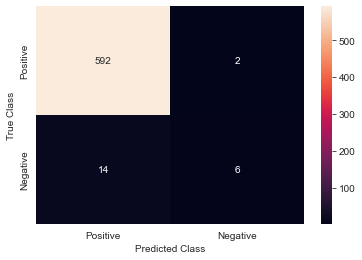

In [167]:
rfc_hyper = RandomForestClassifier(random_state = 0, n_estimators=15, max_depth=argmax_rf_test[0], min_samples_split=argmax_rf_test[1])
rfc_hyper.fit(X_train_processed, y_train)
rfc_f1_hyper_test = evaluate(rfc_hyper, X_test_processed, y_test)

Accuracy score:  0.9674267100977199
precision:  0.5
recall:  0.2
f1:  0.28571428571428575


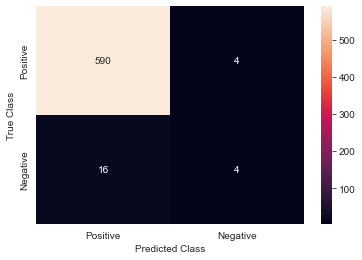

In [168]:
rfc_hyper = RandomForestClassifier(random_state = 0, n_estimators=15, max_depth=argmax_rf[0], min_samples_split=argmax_rf[1])
rfc_hyper.fit(X_train_processed, y_train)
rfc_f1_hyper_test = evaluate(rfc_hyper, X_test_processed, y_test)

Ponownie różnica w wynikach dla modelu z parametrami dobranymi dla próbki treningowej, a dla testowej jest zauważalna. Dla obu doborów parametrów wynik f1-score bardzo się poprawił. Uważamy dostrojenie za trafne, również dlatego, że otrzymany f-score jest lepszy niż dla najlepszych wyników dla próbki treningowej.

In [171]:
scores_table_test = pd.DataFrame({
    'Model': ['LR', 'LR', 'XGBC', 'XGBC', 'RFC', 'RFC'], 
    'Optimised': ['NO', 'YES'] * 3, 
    'F1 Score': [lr_f1_test, lr_f1_hyper_test, xgbc_f1_test, xgbc_f1_hyper_test, rfc_f1_test, rfc_f1_hyper_test]})

<AxesSubplot:xlabel='Model', ylabel='F1 Score'>

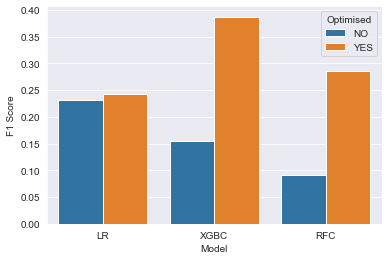

In [172]:
sns.barplot(data=scores_table_test, x = 'Model', y='F1 Score', hue='Optimised')

**Podsumowanie**

W naszej ocenie:
- odpowiednio podzielono dane na próbki
- nie ma zastrzeżeń do preprocessingu
- modele z wykorzystaniem 3 klasyfikatorów zbudowano prawidłowo
- użyto 4 miar oceny jakości klasyfikatorów : accuracy score, precision score, recall score i f1-score, przy czym f1 score uznano za miarę wiodącą.
- wybrano min. 1 hiperparametr i dodatkowo podęjęto próbę ich strojenia

Uważamy, że praca wykonana przez zespół budujący jest bardzo rzetelna. Dużą zaletą jest struktura kodu - stworzone funkcje, które potem wywołano na klasyfikatorach zaowocowały w przejrzystości kodu. Wyniki uzyskane na próbce treningowej w obowiązkowej części pracy domowej - bez strojenia hiperparametrów - są zgodne z wynikami walidacji dla Regresji logistycznej oraz Random forest, rozbieżny wynik dał XGB. Zespół treningowy ambitnie postanowił dostroić parametry dla każdego klasyfikatora. Wówczas rezultaty po dostrojeniu zgadzały się dla XGB i Random Forest, dla Regresji logistycznej wyniki się poprawiły, natomiast nie w takim stopniu jak dla próbki treningowej. Oceniamy dobór parametrów za trafny dla XGB i Random Forest.

Warto zauważyć, że zazwyczaj precicion, recall poprawnie wskazywały różnice między modelami, podczas gdy acuraccy dla każdego modelu było porównywalne i bardzo wysokie. Dopiero miara f1 poprawnie wskazywała różnice między modelami jak i oceniała jakość samego modelu. To pokazuje, jak ważny jest dobór odpowiedniej miary do ewaluacji tworzonych modeli.